In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error,mean_absolute_error
from tensorflow.keras.utils import plot_model
from tensorflow import constant_initializer
import matplotlib.pyplot as plt
import json
import shutil
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

In [2]:
import sys
sys.path.append("../code/")
from model import PhasedSNForecastModel
out_steps = 10

In [3]:
model = PhasedSNForecastModel(units=150, out_steps=out_steps,features = 3)
losses = tf.keras.losses.MeanSquaredError(reduction=tf.keras.losses.Reduction.NONE)
model.compile(optimizer="rmsprop", loss=losses)

In [4]:
def normalize(data):
    masked_data = np.ma.masked_where(data < 0, data)
    min_val = masked_data.min(axis=1)
    max_val = masked_data.max(axis=1)
    
    for i in range(masked_data.shape[1]):
        masked_data.data[:,i,:] = (masked_data.data[:,i,:] - min_val)/(max_val-min_val)
    
    return_data = masked_data.data
    return_data[masked_data.mask] = -1
    return return_data, min_val, max_val
    
def denormalize(data, min_val, max_val):
    masked_data = np.ma.masked_where(data < 0, data)
    
    for i in range(masked_data.shape[1]):
        masked_data.data[:,i,:] = (masked_data.data[:,i,:] * (max_val-min_val))  +  min_val
    
    return_data = masked_data.data
    return_data[masked_data.mask] = -1
    return return_data

In [5]:
data = np.load("../data/padded_x_train.npy")
len_data = data.shape[1]
data, data_min_val, data_max_val = normalize(data)
X_train, y_train = data[:,:-out_steps,:],  data[:,-out_steps:,:]

In [6]:
data_val = np.load("../data/padded_x_val.npy")
len_data = data_val.shape[1]
data_val, data_val_min_val, data_val_max_val = normalize(data_val)
X_val, y_val = data_val[:,:-out_steps,:],  data_val[:,-out_steps:,:]

In [7]:
inputs = X_train
outputs = y_train
inputs_val = X_val
outputs_val = y_val

In [8]:
#Early stops
early_stop = tf.keras.callbacks.EarlyStopping( monitor='val_loss', min_delta=1e-10, patience=10)

#Tensorboard
tensorboard = tf.keras.callbacks.TensorBoard("../data/training/logs")
shutil.rmtree("../data/training/logs",ignore_errors=True)
#Checkpoint
checkpoint = tf.keras.callbacks.ModelCheckpoint("../data/training/model_checkpoints/checkpoint", monitor='val_loss', verbose=0, save_best_only=True)

callbacks = [tensorboard,checkpoint, early_stop] # mag_early_stop,fid_early_stop,dt_early_stop,

In [9]:
MAX_EPOCHS=1000
history = model.fit(inputs,outputs,
                    batch_size=300, 
                    epochs=MAX_EPOCHS, 
                    validation_data=(inputs_val,outputs_val), 
                    callbacks=callbacks)

Epoch 1/1000
 1/11 [=>............................] - ETA: 0s - loss: 0.3966WARNING:tensorflow:From /home/camilo/anaconda3/lib/python3.8/site-packages/tensorflow/python/ops/summary_ops_v2.py:1277: stop (from tensorflow.python.eager.profiler) is deprecated and will be removed after 2020-07-01.
Instructions for updating:
use `tf.profiler.experimental.stop` instead.
11/11 [==============================] - 5s 439ms/step - loss: 0.3001 - val_loss: 0.2042
Epoch 2/1000
11/11 [==============================] - 3s 301ms/step - loss: 0.2381 - val_loss: 0.1656
Epoch 3/1000
11/11 [==============================] - 5s 476ms/step - loss: 0.2136 - val_loss: 0.1484
Epoch 4/1000
11/11 [==============================] - 4s 408ms/step - loss: 0.1966 - val_loss: 0.1300
Epoch 5/1000
11/11 [==============================] - 5s 424ms/step - loss: 0.1805 - val_loss: 0.1138
Epoch 6/1000
11/11 [==============================] - 4s 408ms/step - loss: 0.1673 - val_loss: 0.1103
Epoch 7/1000
11/11 [===============

Epoch 75/1000
11/11 [==============================] - 4s 404ms/step - loss: 0.0527 - val_loss: 0.0510
Epoch 76/1000
11/11 [==============================] - 4s 403ms/step - loss: 0.0518 - val_loss: 0.0502
Epoch 77/1000
11/11 [==============================] - 4s 404ms/step - loss: 0.0522 - val_loss: 0.0505
Epoch 78/1000
11/11 [==============================] - 4s 405ms/step - loss: 0.0524 - val_loss: 0.0503
Epoch 79/1000
11/11 [==============================] - 5s 446ms/step - loss: 0.0515 - val_loss: 0.0503
Epoch 80/1000
11/11 [==============================] - 5s 414ms/step - loss: 0.0518 - val_loss: 0.0501


In [10]:
history_dict = history.history
json.dump(history_dict, open("../data/training/history_model.json", 'w'))

In [11]:
model.save_weights("../data/sn_model.h5")

In [12]:
data_test = np.load("../data/padded_x_val.npy")[:,:,:]
data_test, data_test_min_val, data_test_max_val = normalize(data_test)
X_test, y_test = data_test[:,:-out_steps,:], data_test[:,-out_steps:, :]

#Doing inference on Train data
y_hat_train = model.predict(X_train)
#Denormalizing train
dX_train = denormalize(X_train, data_min_val,data_max_val)
dy_hat_train = denormalize(y_hat_train, data_min_val,data_max_val)
dy_train = denormalize(y_train, data_min_val,data_max_val)

# Doing inference on Test data
y_hat = model.predict(X_test)
# Denormalizing results
dX_test = denormalize(X_test, data_test_min_val,data_test_max_val)
dy_hat = denormalize(y_hat,data_test_min_val,data_test_max_val)
dy_test = denormalize(y_test,data_test_min_val,data_test_max_val)

In [13]:
# Plotting results
features = ["Time", "Mag", "Error"]

In [14]:
maes_test = {}
for i, title in enumerate(features):
    maes_test[title] = []
    for t in range(out_steps):
        maes_test[title].append(mean_absolute_error(y_test[:,t,i], y_hat[:,t,i]))

In [15]:
maes_train = {}
for i, title in enumerate(features):
    maes_train[title] = []
    for t in range(out_steps):
        maes_train[title].append(mean_absolute_error(y_train[:,t,i], y_hat_train[:,t,i]))

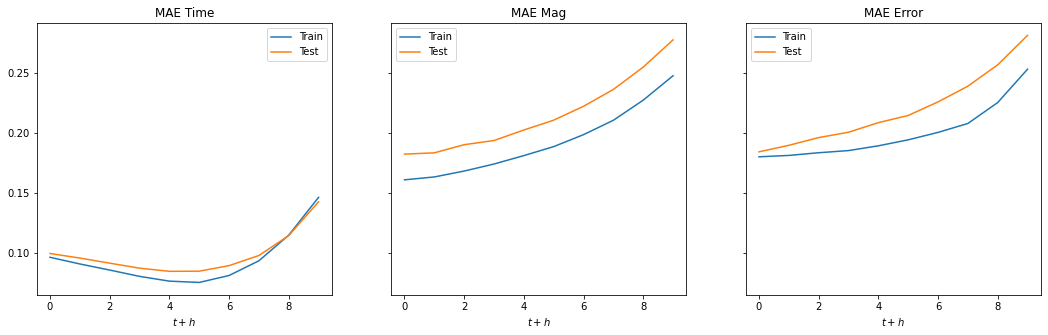

In [16]:
fig,axes = plt.subplots(1,len(features), figsize=(6*len(features),5),sharey=True) 
for i, title in enumerate(features):
    axes[i].plot(maes_train[title], label="Train")
    axes[i].plot(maes_test[title], label="Test")

    axes[i].set_title(f"MAE {title}")
    axes[i].set_xlabel("$t+h$")
    axes[i].legend()

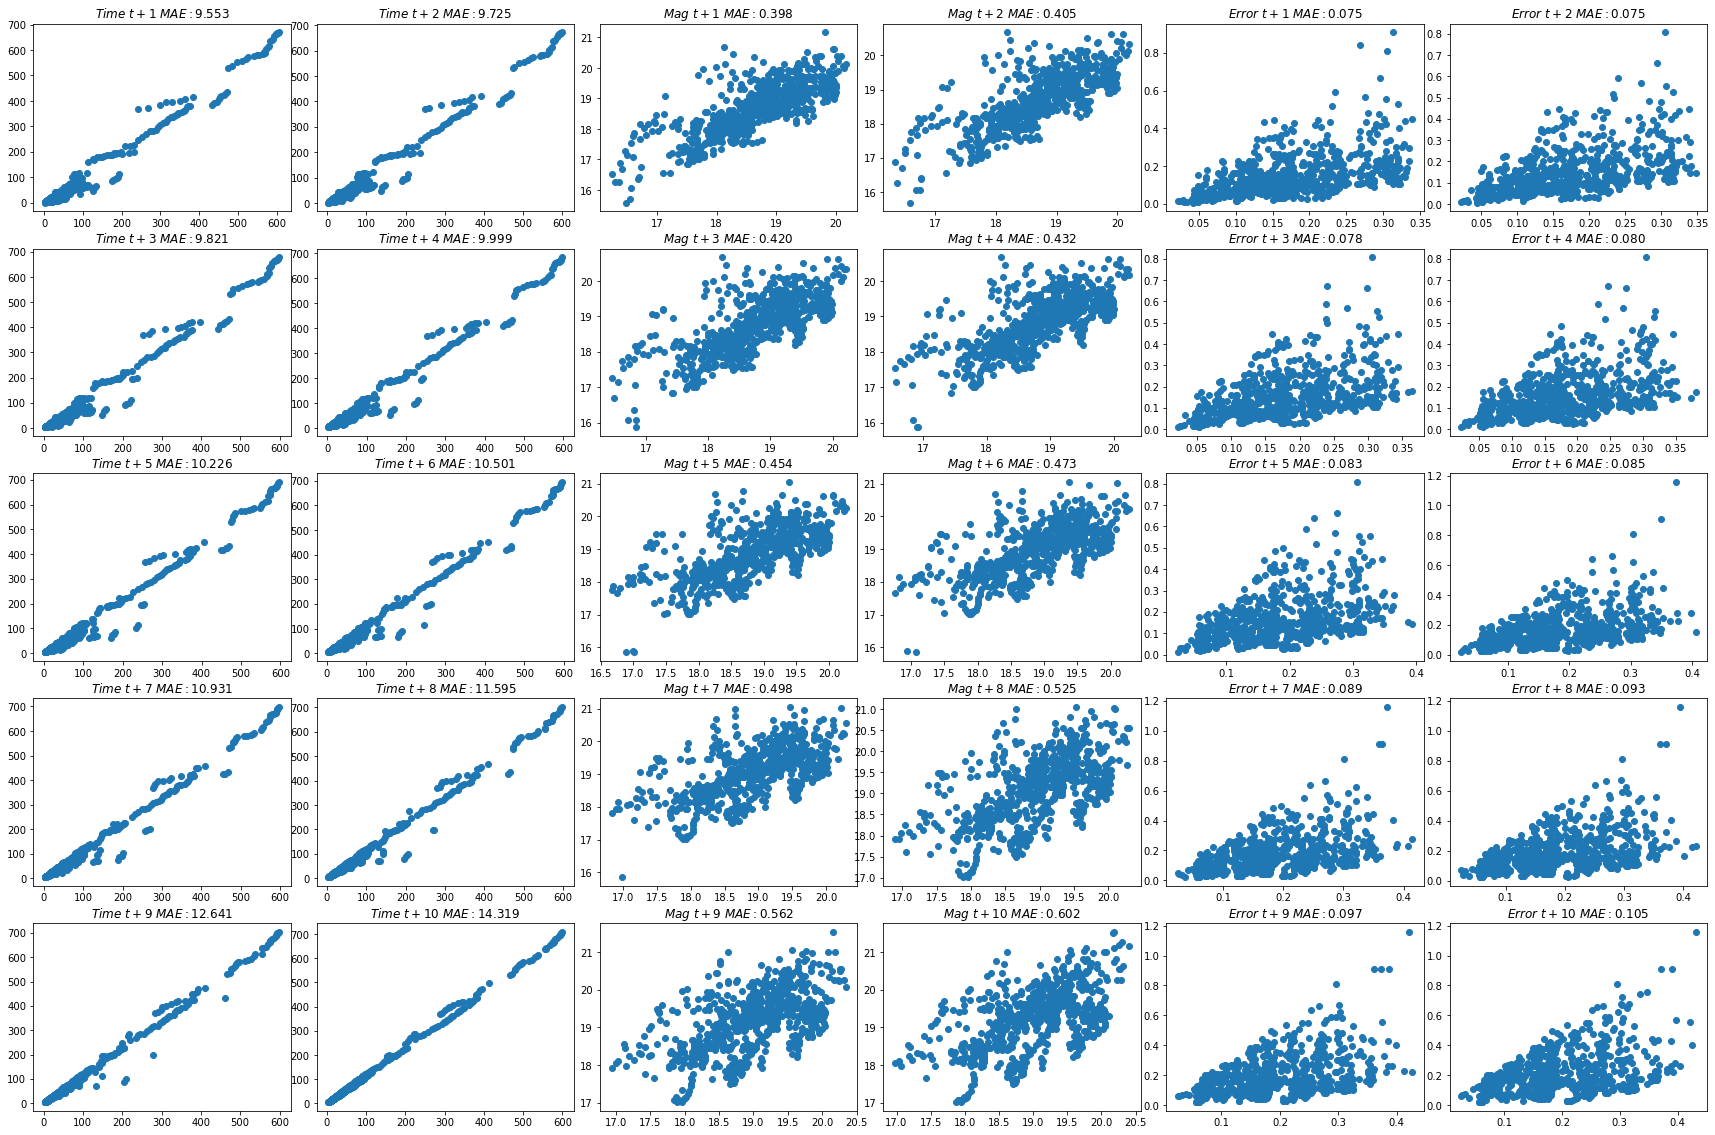

In [17]:
all_rows = np.ceil(out_steps/2).astype(int)
all_columns = len(features)*2
fig2 = plt.figure(figsize=(all_columns*5, all_rows*4))
grid = plt.GridSpec(all_rows, all_columns , wspace=0.1, hspace=0.2)
for i, title in enumerate(features):    
    for t in range(out_steps):
        column = 2*i + (t%2)
        row = t // 2
        
        ax = plt.subplot(grid[row,column])
        mae = mean_absolute_error(dy_test[:,t,i], dy_hat[:,t,i])
        ax.set_title(f"${title} \ t+{t+1} \ MAE:{mae:.3f}$")
        ax.scatter(dy_hat[:,t,i].flatten(),dy_test[:,t,i].flatten())
plt.show()

In [31]:
def plot_data(x, y_real, y_hat, sample=0):
    plt.gca().invert_yaxis()
    x_masked = np.ma.masked_where(x < 0, x)
    plt.scatter(x_masked[sample,:,0], x_masked[sample,:,1], label="History")
    plt.scatter(y_real[sample,:,0], y_real[sample,:,1], label="Real")
    plt.scatter(y_hat[sample,:,0], y_hat[sample,:,1], label="Prediction")
    plt.xlabel("Time $mjd-\min(mjd)$")
    plt.ylabel("Mag")
    
    
f = lambda sample: plot_data(dX_test, dy_test, dy_hat,sample=sample)
interact(f, sample=(0,len(dX_test)-1))

interactive(children=(IntSlider(value=397, description='sample', max=795), Output()), _dom_classes=('widget-in…

<function __main__.<lambda>(sample)>

In [34]:
model.denses

[<tf.Variable 'phased_sn_forecast_model/dense_3/kernel:0' shape=(9, 3) dtype=float32, numpy=
 array([[-0.26564014, -0.3668615 , -0.18176034],
        [ 0.5643201 , -0.35877514, -0.21923216],
        [-0.7703384 ,  0.20789187,  0.01628134],
        [-0.14121704, -0.14024428, -0.06945106],
        [ 0.08566386,  0.39288557,  0.21933383],
        [ 0.20631957,  0.4798638 ,  0.29290858],
        [-0.32887232, -0.13955706, -0.04128879],
        [-0.10532368, -0.15476869, -0.08101232],
        [ 0.59834254, -0.17563158, -0.1160365 ]], dtype=float32)>,
 <tf.Variable 'phased_sn_forecast_model/dense_3/bias:0' shape=(3,) dtype=float32, numpy=array([0.6676425 , 0.4047749 , 0.28410244], dtype=float32)>]